<a href="https://colab.research.google.com/github/gabrielfernandorey/IEBS/blob/main/01_IEBS_Global_Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEBS
### Proyecto fin de Postgrado
--- 
- Metricas
- Alumno: Gabriel Rey

## Clonar repositorio

In [1]:
user='gabrielfernandorey'
git_repository = "https://github.com/"+user+"/IEBS.git"

!git clone {git_repository}

Cloning into 'IEBS'...
remote: Enumerating objects: 12134, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 12134 (delta 57), reused 107 (delta 47), pack-reused 12016
Receiving objects: 100% (12134/12134), 164.29 MiB | 29.30 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (12021/12021), done.


## Importamos librerias

In [2]:
import os
import struct
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import librosa
import librosa.display
from IPython import display as ipd
from PIL import Image

In [3]:
# Setear semilla para reproduccion
seed = 42
np.random.seed(seed)

# Suprimir todos los mensajes de advertencia
warnings.filterwarnings("ignore")

## Importar archivos WAV

In [4]:
filenames = !ls -1 '/content/IEBS/Data'
filenames

['BENTEVEO_COMÚN.wav',
 'CABECITANEGRA_COMÚN.wav',
 'CALANDRIA_GRANDE.wav',
 'CARDENAL_AMARILLO.wav',
 'CARDENAL_COMUN.wav',
 'COTORRA.wav',
 'GOLONDRINA_DOMÉSTICA.wav',
 'GORRIÓN.wav',
 'HORNERO.wav',
 'JILGUERO_DORADO.wav',
 'RUIDO.wav',
 'ZORZAL_COLORADO.wav']

In [5]:
num_samples = len(filenames)
print('Numero total de clases:', num_samples)

Numero total de clases: 12


### Preprocesamiento


Se define una función para la extracción de N muestras

In [6]:
class coefs:
       
    # Global vars
    sr = 44100               # librosa sample rate input
    sec = 10                  # seconds   
    sshape = (128, 128)       # height x width
    fmin = 500               # spectrum min frequency
    fmax = 12500             # spectrum max frequency

In [7]:
def extraer_muestras(filename, n_muestras):
    """
    ARGS
      filename: archivo de audio a procesar
      n_muestras: cantidad de muestras a obtener
    """
    carpeta = filename[:-4]
    path_save = '/content/IEBS/Audioimagen/' + carpeta
    os.makedirs(path_save, exist_ok=True)
        
    audio, _ = librosa.load('/content/IEBS/Data/'+filename)

    for n in range(n_muestras):
        start = np.random.randint(1, len(audio)-(coefs.sec * coefs.sr))
        chunk = audio[start:start + coefs.sec * coefs.sr]

        # Espectrograma para cada segmento de audio -------------------------
        hop_length = int(coefs.sec * coefs.sr / (coefs.sshape[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y = chunk, 
                                                  sr = coefs.sr, 
                                                  n_fft = 1024, 
                                                  hop_length = hop_length, 
                                                  n_mels = coefs.sshape[0], 
                                                  fmin = coefs.fmin, 
                                                  fmax = coefs.fmax)
        
        mel_spec = librosa.power_to_db(mel_spec**2, ref=np.max) 

        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Grabar imagen ------------------------------------------------------
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(path_save+'/'+f'{carpeta}_{n}.png')

    print(f" {carpeta} - {n_muestras} Imágenes generadas")
    
    return 

In [8]:
for i in range(len(filenames)):
  extraer_muestras(filenames[i], 1000)

 BENTEVEO_COMÚN - 1000 Imágenes generadas
 CABECITANEGRA_COMÚN - 1000 Imágenes generadas
 CALANDRIA_GRANDE - 1000 Imágenes generadas
 CARDENAL_AMARILLO - 1000 Imágenes generadas
 CARDENAL_COMUN - 1000 Imágenes generadas
 COTORRA - 1000 Imágenes generadas
 GOLONDRINA_DOMÉSTICA - 1000 Imágenes generadas
 GORRIÓN - 1000 Imágenes generadas
 HORNERO - 1000 Imágenes generadas
 JILGUERO_DORADO - 1000 Imágenes generadas
 RUIDO - 1000 Imágenes generadas
 ZORZAL_COLORADO - 1000 Imágenes generadas


## Modelo Convolucional

In [9]:
import wave
import pylab
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Dropout
from keras.layers.core import Dense, Flatten, Activation

### Preparar datos de entrenamiento

In [10]:
batch_size = 16
img_height = 128
img_width = 128

DATASET_PATH='/content/IEBS/Audioimagen/'

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="training",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 9600 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="validation",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 2400 files for validation.


### Obtener nombre de las clases

In [13]:
class_names = train_ds.class_names
print(class_names)

['BENTEVEO_COMÚN', 'CABECITANEGRA_COMÚN', 'CALANDRIA_GRANDE', 'CARDENAL_AMARILLO', 'CARDENAL_COMUN', 'COTORRA', 'GOLONDRINA_DOMÉSTICA', 'GORRIÓN', 'HORNERO', 'JILGUERO_DORADO', 'RUIDO', 'ZORZAL_COLORADO']


### Modelo CNN + FC
Se modela la red con 4 capas convolucionales y 2 capas densas

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(num_classes, activation='softmax')
])

In [15]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

### Entrenamiento

In [16]:
epochs=5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
600/600 [==============================] - 275s 452ms/step - loss: 0.5163 - accuracy: 0.8604 - val_loss: 0.1172 - val_accuracy: 1.0000
Epoch 2/5
600/600 [==============================] - 259s 432ms/step - loss: 0.1274 - accuracy: 0.9971 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 3/5
600/600 [==============================] - 254s 424ms/step - loss: 0.1150 - accuracy: 0.9996 - val_loss: 0.0874 - val_accuracy: 1.0000
Epoch 4/5
600/600 [==============================] - 265s 441ms/step - loss: 0.1136 - accuracy: 0.9987 - val_loss: 0.0841 - val_accuracy: 1.0000
Epoch 5/5
600/600 [==============================] - 263s 438ms/step - loss: 0.1067 - accuracy: 0.9991 - val_loss: 0.0800 - val_accuracy: 1.0000


In [ ]:
# Guardamos el modelo 
model.save('/content/IEBS/Modelos/modelo.h5')

### Visualización de rendimiento

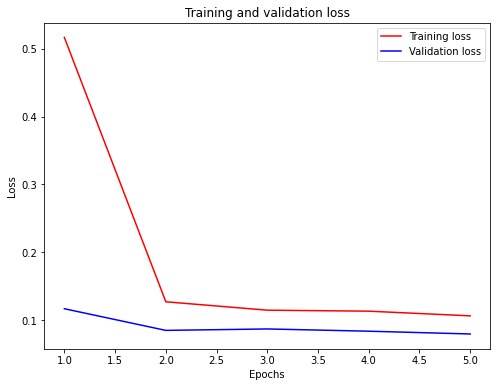

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

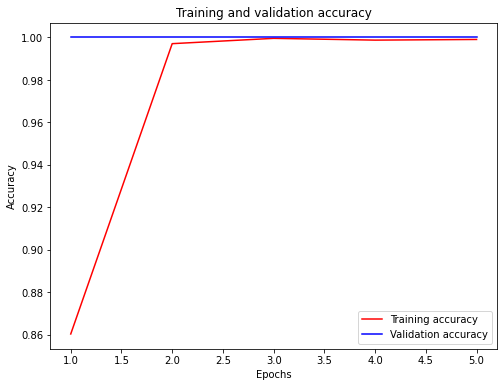

In [18]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Resumen de los valores de loss y accuracy
final_loss, final_acc = model.evaluate(val_ds, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.080023, final accuracy: 1.000000


### Probamos con una imagen conocida aleatoria

In [20]:
from keras.models import load_model

In [ ]:
model = load_model('/content/IEBS/Modelos/modelo.h5')

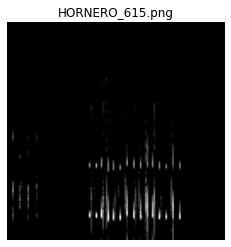

In [ ]:
# Ruta del directorio padre
directorio_padre = '/content/IEBS/Audioimagen/'

# Lista de los subdirectorios
subdirectorios = os.listdir(directorio_padre)

# Elige un subdirectorio al azar
subdirectorio_aleatorio = np.random.choice(subdirectorios)

nro = np.random.randint(0, 1000)
imagen = '/content/IEBS/Audioimagen/' + subdirectorio_aleatorio + '/' + subdirectorio_aleatorio + '_' + str(nro) + '.png'
imagen_rgb = mpimg.imread(imagen) # para visualizar la imagen
plt.axis('off')
plt.title(subdirectorio_aleatorio + '_' + str(nro) + '.png')
plt.imshow(imagen_rgb, cmap='gray');

In [ ]:
# Clasificacion
imagenMod = tf.keras.preprocessing.image.load_img(imagen, target_size=(128,128))
imagenMod = tf.keras.preprocessing.image.img_to_array(imagenMod)
imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

np.set_printoptions(precision=4, suppress=True)
pred = model.predict(imagenMod).astype("float32")
print(pred)
print()
print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 361ms/step
[[0.     0.     0.     0.     0.     0.     0.     0.     0.9999 0.
  0.     0.    ]]

HORNERO


### Aplicacion

In [21]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 KB 2.2 MB/s eta 0:00:00


In [22]:
from pytube import YouTube

In [122]:
def ordenados(acum_pred, acum_indx):
  unicos = np.unique(acum_indx)
  rank = []
  acum=0
  cont=0
  for c in unicos:
    for i in range(len(acum_indx)):
      if c == acum_indx[i]:
        acum += acum_pred[i]  
        cont +=1
    rank.append([c, acum/cont])
    acum=0
    cont=0

  return sorted(rank, key=lambda x: x[1], reverse=True)

In [156]:
def predicciones(url, muestras=10, umbral=0.9):

  # Descargar el audio del video de YouTube
  youtube_url = url
  yt = YouTube(youtube_url)
  yt.streams.filter(only_audio=True)
  yt.streams.first().download('/content/IEBS/Data/', filename='AUDIO_TEST.wav')

  extraer_muestras('AUDIO_TEST.wav', muestras )

  acum_pred = [] 
  acum_indx = [] 

  for i in range(muestras):
    imagen = '/content/IEBS/Audioimagen/AUDIO_TEST/AUDIO_TEST_'+str(i)+'.png'
    imagen_rgb = mpimg.imread(imagen) # para visualizar la imagen

    # Clasificacion
    imagenMod = tf.keras.preprocessing.image.load_img(imagen, target_size=(128,128))
    imagenMod = tf.keras.preprocessing.image.img_to_array(imagenMod)
    imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

    np.set_printoptions(precision=4, suppress=True)
    
    # Prediccion
    pred = model.predict(imagenMod).astype("float32")

    # Acumular indices
    acum_indx.append(np.argmax(pred))

    # Acumular predicciones
    acum_pred.append(pred[0][np.argmax(pred)])
            
    # Procesar predicciones y presentar
    candidatos, votos = np.unique(acum_indx, return_counts=True)

    # Ordenamos candidatos en funcion de los votos
    lista_combinada = list(zip(candidatos, votos))
    lista_ordenada = sorted(lista_combinada, key=lambda x: x[1], reverse=True)
    candidatos, votos = zip(*lista_ordenada)

  print("###################################")
  if len(acum_indx) > len(candidatos) or len(candidatos)==1:

      prob = c = 0
      for i in range(len(acum_indx)):
          if acum_indx[i] == candidatos[np.argmax(votos)]:
              prob += acum_pred[i]
              c = c+1
      prob /= c
      if prob >= umbral:
          print(f"Umbral: {umbral}")
          print(class_names[candidatos[np.argmax(votos)]], end="")
          print(f"  Probabilidad: {round(prob,4)}")
      else:
          print(f"No se puede predecir con umbral >= {umbral}")
          # Calculo por votacion
          print(acum_indx)
          
          orden_votacion = ordenados(acum_pred, acum_indx)
          if votos[0] == votos[1]: # Hay empate(s), define prob.
            print(f"Votacion por mayoria (mas similar a): {class_names[orden_votacion[0][0]]}")
          else:
            print(f"Votacion ponderada por probabilidad (mas similar a): {class_names[candidatos[np.argmax(votos)]]}")
          print("-----------------------------------")
          
  else:
      print("No se puede predecir")
  
  print("###################################")
  print()

  return #acum_pred, acum_indx, candidatos, votos

In [160]:
url = 'https://www.youtube.com/watch?v=D_OvrN0ekao&t=228s' # Zorzal colorado
#url = 'https://www.youtube.com/watch?v=bRPgMuPJeY4&t=331s'  # Benteveo
url = 'https://www.youtube.com/watch?v=R2rW363ydE8&t=29s' # Cabecita negra
#url = 'https://www.youtube.com/watch?v=GRNA_GFeZIs' # Calandria Grande
url = 'https://www.youtube.com/watch?v=f0S6ANb7W1Q&t=1325s' # Cardenal amarillo
#url = 'https://www.youtube.com/watch?v=cO0bsV8vePg' # Cardenal comun
#url = 'https://www.youtube.com/watch?v=oibxurOe1zE' # Cotorra
#url = 'https://www.youtube.com/watch?v=zsvapbpmwNY&t=110s' #Golondrina domestica x
url = 'https://www.youtube.com/watch?v=TPuG-FOa1yw&t=971s' # Gorrion x
url = 'https://www.youtube.com/watch?v=6hZtOsnc7SE' # Hornero x
#url = 'https://www.youtube.com/watch?v=kviBd6K-eF4&t=438s' # Jilguero dorado

predicciones(url, muestras=15, umbral=0.8 )

 AUDIO_TEST - 15 Imágenes generadas
1/1 [==============================] - 0s 40ms/step
###################################
No se puede predecir con umbral >= 0.8
[6, 1, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Votacion ponderada por probabilidad (mas similar a): GOLONDRINA_DOMÉSTICA
-----------------------------------
###################################

